# Test for the Content-based matrix factorization on random matrices

### This file are the testing for the potential models of our recommendation system

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import sys
from sklearn.metrics import jaccard_similarity_score
import seaborn as sns
import matplotlib.pyplot as plt
import math

### We create a random matrix which simulates the evenual matrix of features per hotel

In [10]:
len_feat = 10
num_observations = 100

matrix = np.random.rand(num_observations, len_feat)

### We fill the matrix randomly with 0s because we assume we will not have all the data from some of the features


In [11]:
nan_mat = np.random.random(matrix.shape)<0.2
item_representation = pd.DataFrame(data = matrix)
headers = ['feature-'+str(i+1) for i in range(10)]
item_representation.columns = headers
item_representation = item_representation.mask(nan_mat)
item_representation = item_representation.fillna(100)
item_representation.head()



,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,feature-10
0,0.320001,0.578863,0.567501,100.000000,100.000000,0.687381,0.441453,100.000000,100.000000,0.512120
1,0.690772,0.250250,0.158531,0.550165,0.456119,0.121338,0.572188,0.777801,100.000000,0.831137
2,0.527326,0.606611,0.844864,0.628471,0.884732,0.388860,100.000000,0.669278,100.000000,0.317248
3,0.974537,0.183079,100.000000,0.440845,0.251661,0.987039,0.763241,0.435406,100.000000,0.793249
4,0.694128,0.828343,0.021029,0.341547,0.571822,0.625947,0.219682,0.079001,0.277391,0.213051


### We instantiate the matrices for the user representaiton

In [12]:
len_hotels = 100
num_users = 1000
user_rep_matrix = np.random.rand(num_users, len_hotels)


In [13]:

user_representation = pd.DataFrame(data = user_rep_matrix)
user_representation.head()



,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.036554,0.226029,0.480279,0.196555,0.699870,0.659945,0.785204,0.303063,0.491595,0.849826,...,0.752214,0.427995,0.691897,0.763144,0.423504,0.141020,0.901826,0.655411,0.414075,0.404028
1,0.399594,0.340009,0.158768,0.351581,0.004314,0.687071,0.036045,0.325449,0.349075,0.812526,...,0.406540,0.715781,0.982015,0.084823,0.828841,0.708834,0.167551,0.923406,0.772840,0.346460
2,0.303343,0.758811,0.135042,0.598706,0.202561,0.633227,0.700318,0.124069,0.871320,0.222913,...,0.164594,0.152806,0.835758,0.931201,0.781354,0.684363,0.538832,0.747177,0.768416,0.597210
3,0.414521,0.449374,0.708547,0.460511,0.650266,0.498844,0.680631,0.188221,0.356168,0.061981,...,0.360625,0.924355,0.049270,0.893083,0.381355,0.828660,0.290064,0.899392,0.275658,0.090432
4,0.649383,0.505849,0.639921,0.492608,0.450160,0.587804,0.534575,0.744068,0.421548,0.832450,...,0.812266,0.889728,0.153963,0.962800,0.036013,0.674964,0.135297,0.596176,0.301577,0.477411


In [14]:
headers = ['hotel_id-'+str(i) for i in range(100)]
user_representation.columns = headers

### we then change the random values to star ratings

In [15]:
def get_rating(x):
    x = x/2
    value = np.round(x, 1)
    return value*10
for header in headers:
    user_representation[header] = user_representation[header].apply(lambda x: get_rating(x) if pd.isna(x) is False else x )
user_representation

,hotel_id-0,hotel_id-1,hotel_id-2,hotel_id-3,hotel_id-4,hotel_id-5,hotel_id-6,hotel_id-7,hotel_id-8,hotel_id-9,...,hotel_id-90,hotel_id-91,hotel_id-92,hotel_id-93,hotel_id-94,hotel_id-95,hotel_id-96,hotel_id-97,hotel_id-98,hotel_id-99
0,0.0,1.0,2.0,1.0,3.0,3.0,4.0,2.0,2.0,4.0,...,4.0,2.0,3.0,4.0,2.0,1.0,5.0,3.0,2.0,2.0
1,2.0,2.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,4.0,...,2.0,4.0,5.0,0.0,4.0,4.0,1.0,5.0,4.0,2.0
2,2.0,4.0,1.0,3.0,1.0,3.0,4.0,1.0,4.0,1.0,...,1.0,1.0,4.0,5.0,4.0,3.0,3.0,4.0,4.0,3.0
3,2.0,2.0,4.0,2.0,3.0,2.0,3.0,1.0,2.0,0.0,...,2.0,5.0,0.0,4.0,2.0,4.0,1.0,4.0,1.0,0.0
4,3.0,3.0,3.0,2.0,2.0,3.0,3.0,4.0,2.0,4.0,...,4.0,4.0,1.0,5.0,0.0,3.0,1.0,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.0,2.0,5.0,3.0,1.0,3.0,3.0,4.0,4.0,1.0,...,1.0,3.0,0.0,2.0,3.0,2.0,0.0,4.0,1.0,2.0
996,3.0,3.0,5.0,3.0,4.0,3.0,1.0,0.0,5.0,3.0,...,2.0,2.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,3.0
997,4.0,3.0,4.0,1.0,1.0,0.0,1.0,3.0,5.0,2.0,...,2.0,0.0,2.0,0.0,2.0,3.0,3.0,2.0,4.0,2.0
998,0.0,3.0,3.0,0.0,4.0,4.0,5.0,1.0,3.0,3.0,...,1.0,4.0,0.0,3.0,5.0,0.0,3.0,3.0,1.0,1.0


### we fill some of the data with a value which for us represents no ratin 

In [16]:
nat_mat = np.random.random(user_rep_matrix.shape)<.6
user_representation = user_representation.mask(nat_mat)
user_representation = user_representation.fillna(0)

### we then split the data into test and train


In [17]:
mask_test_train = np.random.random(user_representation.shape)<0.2
user_rep_train = user_representation.mask(mask_test_train)
user_rep_train = user_rep_train.replace({100: None})
user_rep_train

,hotel_id-0,hotel_id-1,hotel_id-2,hotel_id-3,hotel_id-4,hotel_id-5,hotel_id-6,hotel_id-7,hotel_id-8,hotel_id-9,...,hotel_id-90,hotel_id-91,hotel_id-92,hotel_id-93,hotel_id-94,hotel_id-95,hotel_id-96,hotel_id-97,hotel_id-98,hotel_id-99
0,0.0,1.0,NaN,NaN,3.0,0.0,4.0,2.0,0.0,0.0,...,0.0,2.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,2.0
1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,...,0.0,0.0,NaN,0.0,NaN,4.0,0.0,0.0,NaN,2.0
2,2.0,4.0,1.0,0.0,0.0,NaN,4.0,1.0,NaN,0.0,...,1.0,1.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0
3,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
4,3.0,3.0,3.0,2.0,0.0,3.0,3.0,0.0,2.0,0.0,...,NaN,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.0,0.0,5.0,0.0,NaN,NaN,3.0,NaN,0.0,1.0,...,1.0,3.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
996,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,...,0.0,0.0,NaN,0.0,4.0,NaN,0.0,NaN,0.0,3.0
997,4.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
998,0.0,0.0,0.0,0.0,4.0,4.0,5.0,1.0,3.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,3.0,0.0,NaN


### test set is very sparse

In [18]:
user_rep_test = user_representation.where(mask_test_train)
##we the replace the 100 value with NaN
user_rep_test = user_rep_test.replace({100: None})
user_rep_test

,hotel_id-0,hotel_id-1,hotel_id-2,hotel_id-3,hotel_id-4,hotel_id-5,hotel_id-6,hotel_id-7,hotel_id-8,hotel_id-9,...,hotel_id-90,hotel_id-91,hotel_id-92,hotel_id-93,hotel_id-94,hotel_id-95,hotel_id-96,hotel_id-97,hotel_id-98,hotel_id-99
0,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,0.0,3.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.0,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN
997,NaN,3.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


# Model for the Content-Based Filtering

### first we fill the None with 0

In [20]:
# user_rep_train = user_rep_train.fillna(0)
# user_rep_test = user_rep_test.fillna(0)
item_representation = item_representation.fillna(0)
item_representation = item_representation.replace(100,0)

### The method used in this test file is matrix factorization to 2 dimensions, we compare item similarity, but it could be useful to compare user similarity as well

In [21]:


svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
factorized_item_rep = svd.fit_transform(item_representation)
factorized_item_rep.shape


factorized_user_rep = svd.fit_transform(user_representation)




### we might want to try the jaccard similarity or dice coefficient instead of matrix factorization

In [ ]:
# list2pd = []
# for i, row1 in enumerate(factorized_item_rep):
#     dico2list = dict()
#     dico2list['hotel-'+str(i)] = []
#     for row2 in factorized_item_rep:
#         if [x for x in row1] == [x for x in row2]:
#             dico2list['hotel-'+str(i)].append(None)
#         else:
#             dico2list['hotel-'+str(i)].append(jaccard_similarity_score(row1, row2))
#     list2pd.append(dico2list)

# jacquard_distances = pd.DataFrame(data = list2pd)
# jacquard_distances

### We plot the hotels on a scatterplot based on their reduced dimension features

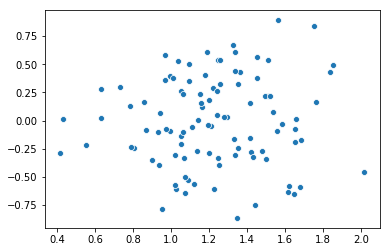

In [22]:
sns.scatterplot(factorized_item_rep[:,0], factorized_item_rep[:,1])
plt.show()

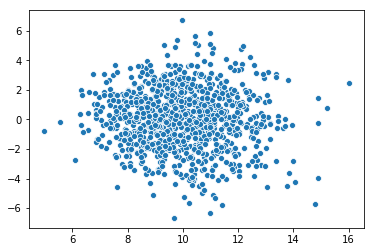

In [23]:
sns.scatterplot(factorized_user_rep[:,0], factorized_user_rep[:,1])
plt.show()


### these visualizations look totally random! That's because they are!!!

...


# Evaluating our model 

In [24]:
def euclid(array1, array2):
    x = pow((array1[0]-array2[0]), 2) + pow((array1[1]-array2[1]), 2)
    distance = math.sqrt(x)
    return distance
def isclose(hotel1, hotels_liked, threshold):
    for hotel in hotels_liked:
        if euclid(factorized_item_rep[hotel1], factorized_item_rep[hotel[0]]) > threshold:
            return True                   
        else:
            return False

In [25]:
user_anonymous = []
thresholds = [.5]
tp = 0
fp = 0
tn = 0
fn = 0
for t in thresholds:
    for (i, r), (idx, row) in zip(user_rep_train.iterrows(), user_rep_test.iterrows()):
        recommend = []
        hotels_to_evaluate = [(num, row[x]) for num, x in enumerate(user_rep_test.columns) if row[x]]
        if not hotels_to_evaluate:
            break
        hotels_liked = [(num, r[x]) for num, x in enumerate(user_rep_train.columns) if r[x] and r[x] > 3]
        if not hotels_liked:
            user_anonymous.append(i)
        else:
            for hotel in hotels_to_evaluate:
                if isclose(hotel[0], hotels_liked, t):
                    recommend.append(hotel)
            if recommend:
                for hotel in hotels_to_evaluate:
                    if hotel[1] > 3 and hotel in recommend:
                        tp += 1
                    if hotel[1] <= 3 and hotel in recommend:
                        fp += 1
                    if hotel[1] > 3 and hotel not in recommend:
                        fn += 1
                    if hotel[1] <= 3 and hotel not in recommend:
                        tn += 1
            else:
                fn += len([hotel for hotel in hotels_to_evaluate if hotel[1] > 3])
                tn += len([hotel for hotel in hotels_to_evaluate if hotel[1] <= 3])
    print(tp, fn, fp, tn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    F1 = 2*(precision*recall)/(precision+recall)
    print('============================')
    print("evaluating at threshold ", t)
    print("recall",recall)
    print("precision",precision)
    print("F1",F1)

    
                               

1261 1013 2733 2010
evaluating at threshold  0.5
recall 0.5545294635004397
precision 0.3157235853780671
F1 0.40236119974473517


### something to take into account would be that we can compute the item factorization/similarity after zooming in on k-nearest users...

### we should consider each customer to have features such as which hotels visited, the things they mention in their reviews, some other things like thigs...